<a href="https://colab.research.google.com/github/AP-047/RClass-Classification-by-Rational-Approximation/blob/main/notebooks/1D_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Training**

In [ ]:
import numpy as np
from scipy.optimize import linprog

# Target function
def target_function(x):
    return np.abs(x - 0.1)

# Rational function (coefficients to be optimized later)
def rational_function(x, alpha, beta):
    """
    r(x) = (α_0 + α_1*x + ...)/(β_0 + β_1*x + ...).
    """
    numerator = sum(alpha[i] * x**i for i in range(len(alpha)))
    denominator = sum(beta[i] * x**i for i in range(len(beta)))
    return numerator / denominator

# Feasibility check function
def check_feasibility_and_compute_coefficients(z, x_data, y_data, degree):
    num_data_points = len(x_data)
    num_coefficients = degree + 1  # Number of coefficients for num & den

    # Construct the G(x) and H(x) polynomials
    G = np.array([[x**i for i in range(num_coefficients)] for x in x_data])  # Numerator polynomial
    H = np.array([[x**i for i in range(num_coefficients)] for x in x_data])  # Denominator polynomial

    # Construct constraints for Ax <= b
    A = []
    b = []

    for i in range(num_data_points):
        f_plus_z = y_data[i] + z
        f_minus_z = y_data[i] - z

        # Constraint 1: (f(xi) - z) * β^T H(xi) - α^T G(xi) ≤ θ
        constraint_1 = np.zeros(2 * num_coefficients + 1)
        constraint_1[:num_coefficients] = -G[i]  # Coefficients of α
        constraint_1[num_coefficients:2 * num_coefficients] = (f_minus_z) * H[i]  # Coefficients of β
        constraint_1[-1] = -1  # Coefficient of θ
        A.append(constraint_1)
        b.append(0)

        # Constraint 2: α^T G(xi) - (f(xi) - z) * β^T H(xi) ≤ θ
        constraint_2 = np.zeros(2 * num_coefficients + 1)
        constraint_2[:num_coefficients] = G[i]  # Coefficients of α
        constraint_2[num_coefficients:2 * num_coefficients] = -(f_minus_z) * H[i]  # Coefficients of β
        constraint_2[-1] = -1  # Coefficient of θ
        A.append(constraint_2)
        b.append(0)

    # Positive constraints: β^T H(x) ≥ δ (small positive number)
    delta = 1e-6
    for i in range(num_data_points):
        constraint_pos = np.zeros(2 * num_coefficients + 1)
        constraint_pos[num_coefficients:2 * num_coefficients] = -H[i]  # Coefficients of β
        A.append(constraint_pos)
        b.append(-delta)

    # Convert to numpy arrays
    A = np.array(A)
    b = np.array(b)

    # Objective function to minimize θ
    c = np.zeros(2 * num_coefficients + 1)
    c[-1] = 1  # Only θ has a coefficient in the objective function

    # Solve the linear programming problem
    result = linprog(c, A_ub=A, b_ub=b, method="highs")

    # Check feasibility and return results
    if result.success:
        alpha_coefficients = result.x[:num_coefficients]
        beta_coefficients = result.x[num_coefficients:2 * num_coefficients]
        theta = result.x[-1]
        return True, alpha_coefficients, beta_coefficients, theta
    else:
        return False, None, None, None

# Bisection loop
def bisection_loop(x_data, y_data, degree, uL, uH, precision):
    optimal_alpha, optimal_beta, optimal_theta = None, None, None

    while uH - uL > precision:
        z = (uL + uH) / 2
        feasible, alpha_coefficients, beta_coefficients, theta = check_feasibility_and_compute_coefficients(z, x_data, y_data, degree)

        if feasible:
            uH = z
            optimal_alpha, optimal_beta, optimal_theta = alpha_coefficients, beta_coefficients, theta
        else:
            uL = z

    return uH, optimal_alpha, optimal_beta, optimal_theta

# Main execution
if __name__ == "__main__":
    # Data setup
    degree = 2  # Polynomial degree
    x_data = np.linspace(-0.5, 0.5, 50)  # Discretized data points
    y_data = target_function(x_data)  # Target values

    # Initial coefficients for the rational function (to be optimized)
    alpha_initial = [5, 3, 2]  # Coefficients of numerator
    beta_initial = [7, 4, 0]   # Coefficients of denominator

    # Bisection parameters
    uL = 0  # Initial lower bound
    uH = 100  # Initial upper bound
    precision = 1e-6  # Precision threshold

    # Run bisection loop
    optimal_z, optimal_alpha, optimal_beta, optimal_theta = bisection_loop(x_data, y_data, degree, uL, uH, precision)

    # Print results
    print(f"Optimal Z (Maximum Deviation): {optimal_z}")
    print(f"Optimized Coefficients (Numerator α): {optimal_alpha}")
    print(f"Optimized Coefficients (Denominator β): {optimal_beta}")
    print(f"Optimal θ: {optimal_theta}")
    print(f"rational_function: {rational_function}")


Optimal Z (Maximum Deviation): 7.450580596923828e-07
Optimized Coefficients (Numerator α): [2.89660252e-08 0.00000000e+00 7.35526091e-06]
Optimized Coefficients (Denominator β): [1.01809335e-06 1.89178749e-06 1.16266150e-05]
Optimal θ: 8.047145751821928e-08
rational_function: <function rational_function at 0x7a70e3f31fc0>


**Testing**

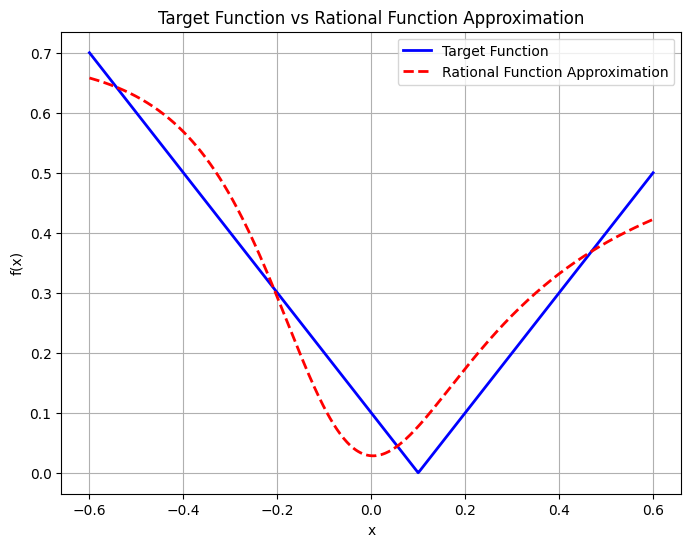

In [ ]:
import matplotlib.pyplot as plt

def plot_functions(target_function, rational_function, alpha, beta, x_range):
    # Generate points for the plot
    x_test = np.linspace(x_range[0], x_range[1], 500)
    y_target = target_function(x_test)
    y_rational = [rational_function(x, alpha, beta) for x in x_test]

    # Plot the functions
    plt.figure(figsize=(8, 6))
    plt.plot(x_test, y_target, label="Target Function", color="blue", linewidth=2)
    plt.plot(x_test, y_rational, label="Rational Function Approximation", color="red", linestyle="--", linewidth=2)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Target Function vs Rational Function Approximation")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution for plotting
if __name__ == "__main__":
    # Test points range for plotting
    x_range = [-0.6, 0.6]

    # Call the plotting function
    plot_functions(target_function, rational_function, optimal_alpha, optimal_beta, x_range)
